## Imports


In [1]:
import copy
import pandas as pd
import random
import seaborn as sns
import torch
import torch.utils.data
import torchvision
import cv2
import torchmetrics
import numpy as np

from matplotlib import pyplot as plt
from pathlib import Path
from torch import nn
from torchvision import io, transforms
from torchvision.transforms import functional, Resize
from tqdm.auto import tqdm, trange

## Dataset

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

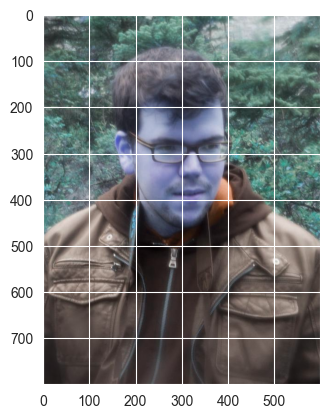

In [2]:
img = cv2.imread("..\\..\\data\\dataset\\images\\1803260459-00000416.jpg", cv2.IMREAD_UNCHANGED)
mask = cv2.imread("""..\\..\\data\\dataset\\masks\\1803260459-00000416.png""", cv2.IMREAD_UNCHANGED)[..., -1]
plt.imshow(img)

In [3]:
SEED = 128
def set_seed():


    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
set_seed()

In [4]:
from glob import glob

imgs_list = glob("..\\..\\data\\dataset\\images\\*")

In [5]:
from torch.utils.data import Dataset
import numpy as np
import torch

class SelfieDataset(Dataset):
    def __init__(self, imgs_list):
        self.imgs = imgs_list

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = cv2.imread(self.imgs[idx])[..., ::-1]

        mask_path = self.imgs[idx].split("\\")
        mask_path[-2] = "masks"
        mask_path[-1] = mask_path[-1][:-4] + ".png"

        mask_path = "\\".join(mask_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        img = cv2.resize(img[100:-100], (256, 256))
        mask = cv2.resize(mask[100:-100], (256, 256)) > 100

        mask = torch.Tensor(mask.astype(int))[None, ...]
        img = torch.Tensor(img.copy()).permute(2, 0, 1) / 255.

        return {"image": img, "mask": mask}

In [6]:
from sklearn.model_selection import train_test_split
train , test = train_test_split(imgs_list, test_size=0.2, random_state=SEED)
train, valid = train_test_split(train, test_size=0.2, random_state=SEED)


## UNET

In [7]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module): 
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

In [8]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

In [9]:
class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

In [10]:
net = UNET(3, 16, 1)

In [11]:
from torch import optim

criterion = nn.BCEWithLogitsLoss()
# jaccard = torchmetrics.classification.BinaryJaccardIndex()
jaccard = torchmetrics.JaccardIndex(task="binary")
net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

## Overfitting

In [12]:
overfitting_loader = torch.utils.data.DataLoader(SelfieDataset(train[-8:]), batch_size=8, shuffle=True, num_workers=0)

In [13]:
def train_model(unet, optimizer, train_l, test_l, epochs = 10, checkpath=None):
  results = {'loss_train': [],
           'loss_test': [],
           'jac_train': [],
           'jac_test': []
           }
  prev_loss = 1000.0
  for epoch in range(epochs):
      print("epoch:", epoch)
      unet.train()
      running_loss = 0.0
      running_jaccard = 0.0
      for data in tqdm(train_l, disable=False):
        x = data['image'].cuda()
        y = data['mask'].cuda()
        optimizer.zero_grad()
        outputs = unet(x) # (4, 10)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_jaccard += jaccard(outputs.cpu(), y.cpu() > jaccard.threshold).item()
      res_loss = running_loss / len(train_l)
      res_jaccard = running_jaccard / len(train_l)

      
      
      
      unet.eval()
      test_loss = 0.0
      test_jaccard = 0.0
      with torch.no_grad():
        for data in tqdm(test_l, disable=False):
          x = data['image'].cuda()
          y = data['mask'].cuda()
          pred = unet(x)
          test_loss += criterion(pred, y).item()
          test_jaccard += jaccard(pred.cpu(), y.cpu()> jaccard.threshold).item()
      results['loss_train'].append(res_loss)
      results['loss_test'].append(test_loss / len(test_l))
      results['jac_train'].append(res_jaccard)
      results['jac_test'].append(test_jaccard / len(test_l))
      
      if checkpath is not None and test_loss < prev_loss:
        prev_loss = test_loss
        #delete previous model
        if Path(checkpath).exists():
            Path(checkpath).unlink()
        torch.save(unet.state_dict(), checkpath)
        print("Model saved")
      # pretty print
      print(f"Loss train: {res_loss:.4f}, Loss test: {test_loss / len(test_l):.4f}, Jaccard train: {res_jaccard:.4f}, Jaccard test: {test_jaccard / len(test_l):.4f}")

  print(f'Best epoch: {np.argmin(results["loss_test"])}')
  return results


In [14]:
test_loader = torch.utils.data.DataLoader(SelfieDataset(test), batch_size=64, shuffle=False)
res = train_model(net, optimizer, overfitting_loader, test_loader, epochs = 50)
df = pd.DataFrame(res)
df

epoch: 0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.7224, Loss test: 0.6975, Jaccard train: 0.1398, Jaccard test: 0.0000
epoch: 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.6945, Loss test: 0.6979, Jaccard train: 0.1583, Jaccard test: 0.0000
epoch: 2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.6734, Loss test: 0.6984, Jaccard train: 0.1973, Jaccard test: 0.0000
epoch: 3


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.6536, Loss test: 0.6990, Jaccard train: 0.2639, Jaccard test: 0.0000
epoch: 4


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.6343, Loss test: 0.6996, Jaccard train: 0.3397, Jaccard test: 0.0000
epoch: 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.6147, Loss test: 0.7003, Jaccard train: 0.4064, Jaccard test: 0.0000
epoch: 6


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.5947, Loss test: 0.7012, Jaccard train: 0.4654, Jaccard test: 0.0000
epoch: 7


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.5732, Loss test: 0.7023, Jaccard train: 0.5224, Jaccard test: 0.0000
epoch: 8


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.5521, Loss test: 0.7038, Jaccard train: 0.5772, Jaccard test: 0.0000
epoch: 9


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.5327, Loss test: 0.7057, Jaccard train: 0.6290, Jaccard test: 0.0000
epoch: 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.5160, Loss test: 0.7084, Jaccard train: 0.6694, Jaccard test: 0.0000
epoch: 11


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.5013, Loss test: 0.7123, Jaccard train: 0.7050, Jaccard test: 0.0000
epoch: 12


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.4870, Loss test: 0.7177, Jaccard train: 0.7348, Jaccard test: 0.0000
epoch: 13


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.4703, Loss test: 0.7247, Jaccard train: 0.7734, Jaccard test: 0.0000
epoch: 14


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.4591, Loss test: 0.7334, Jaccard train: 0.7972, Jaccard test: 0.0000
epoch: 15


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.4477, Loss test: 0.7443, Jaccard train: 0.8200, Jaccard test: 0.0000
epoch: 16


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.4354, Loss test: 0.7574, Jaccard train: 0.8485, Jaccard test: 0.0000
epoch: 17


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.4255, Loss test: 0.7718, Jaccard train: 0.8683, Jaccard test: 0.0000
epoch: 18


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.4170, Loss test: 0.7865, Jaccard train: 0.8748, Jaccard test: 0.0000
epoch: 19


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.4081, Loss test: 0.8011, Jaccard train: 0.8952, Jaccard test: 0.0000
epoch: 20


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3992, Loss test: 0.8139, Jaccard train: 0.9148, Jaccard test: 0.0000
epoch: 21


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3919, Loss test: 0.8253, Jaccard train: 0.9272, Jaccard test: 0.0000
epoch: 22


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3845, Loss test: 0.8375, Jaccard train: 0.9348, Jaccard test: 0.0000
epoch: 23


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3774, Loss test: 0.8499, Jaccard train: 0.9403, Jaccard test: 0.0000
epoch: 24


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3718, Loss test: 0.8616, Jaccard train: 0.9456, Jaccard test: 0.0000
epoch: 25


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3669, Loss test: 0.8697, Jaccard train: 0.9549, Jaccard test: 0.0000
epoch: 26


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3621, Loss test: 0.8753, Jaccard train: 0.9631, Jaccard test: 0.0000
epoch: 27


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3584, Loss test: 0.8809, Jaccard train: 0.9640, Jaccard test: 0.0000
epoch: 28


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3539, Loss test: 0.8866, Jaccard train: 0.9691, Jaccard test: 0.0001
epoch: 29


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3506, Loss test: 0.8929, Jaccard train: 0.9698, Jaccard test: 0.0003
epoch: 30


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3473, Loss test: 0.8995, Jaccard train: 0.9726, Jaccard test: 0.0005
epoch: 31


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3445, Loss test: 0.9048, Jaccard train: 0.9746, Jaccard test: 0.0014
epoch: 32


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3418, Loss test: 0.9069, Jaccard train: 0.9770, Jaccard test: 0.0041
epoch: 33


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3393, Loss test: 0.9066, Jaccard train: 0.9788, Jaccard test: 0.0088
epoch: 34


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3369, Loss test: 0.9063, Jaccard train: 0.9784, Jaccard test: 0.0152
epoch: 35


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3348, Loss test: 0.9069, Jaccard train: 0.9775, Jaccard test: 0.0250
epoch: 36


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3328, Loss test: 0.9058, Jaccard train: 0.9790, Jaccard test: 0.0414
epoch: 37


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3307, Loss test: 0.9007, Jaccard train: 0.9824, Jaccard test: 0.0620
epoch: 38


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3291, Loss test: 0.8914, Jaccard train: 0.9830, Jaccard test: 0.0828
epoch: 39


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3272, Loss test: 0.8789, Jaccard train: 0.9836, Jaccard test: 0.1067
epoch: 40


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3255, Loss test: 0.8630, Jaccard train: 0.9822, Jaccard test: 0.1373
epoch: 41


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3238, Loss test: 0.8450, Jaccard train: 0.9822, Jaccard test: 0.1709
epoch: 42


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3222, Loss test: 0.8239, Jaccard train: 0.9836, Jaccard test: 0.2073
epoch: 43


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3206, Loss test: 0.8014, Jaccard train: 0.9846, Jaccard test: 0.2444
epoch: 44


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3191, Loss test: 0.7773, Jaccard train: 0.9856, Jaccard test: 0.2833
epoch: 45


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3176, Loss test: 0.7517, Jaccard train: 0.9851, Jaccard test: 0.3228
epoch: 46


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3161, Loss test: 0.7271, Jaccard train: 0.9852, Jaccard test: 0.3608
epoch: 47


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3147, Loss test: 0.7065, Jaccard train: 0.9859, Jaccard test: 0.3936
epoch: 48


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3132, Loss test: 0.6881, Jaccard train: 0.9869, Jaccard test: 0.4228
epoch: 49


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3118, Loss test: 0.6706, Jaccard train: 0.9869, Jaccard test: 0.4481
Best epoch: 49


loss_train  loss_test  jac_train  jac_test
0     0.722425   0.697532   0.139850  0.000000
1     0.694470   0.697906   0.158301  0.000000
2     0.673363   0.698404   0.197284  0.000000
3     0.653631   0.698957   0.263879  0.000000
4     0.634272   0.699574   0.339654  0.000000
5     0.614749   0.700298   0.406443  0.000000
6     0.594749   0.701188   0.465383  0.000000
7     0.573194   0.702317   0.522438  0.000000
8     0.552059   0.703763   0.577183  0.000000
9     0.532665   0.705679   0.628982  0.000000
10    0.516032   0.708357   0.669449  0.000000
11    0.501272   0.712274   0.704950  0.000000
12    0.487034   0.717721   0.734809  0.000000
13    0.470263   0.724741   0.773430  0.000000
14    0.459106   0.733423   0.797233  0.000000
15    0.447664   0.744342   0.819967  0.000000
16    0.435446   0.757430   0.848463  0.000000
17    0.425533   0.771762   0.868311  0.000000
18    0.416956   0.786518   0.874772  0.000000
19    0.408059   0.801147   0.895202  0.000000
20    0.399168   0.813863   0.914799  0.000000
21    0.391851   0.825348   0.927167  0.000000
22    0.384546   0.837481   0.934766  0.000000
23    0.377361   0.849919   0.940286  0.000000
24    0.371798   0.861581   0.945650  0.000000
25    0.366921   0.869730   0.954919  0.000000
26    0.362113   0.875276   0.963054  0.000000
27    0.358449   0.880906   0.964031  0.000021
28    0.353892   0.886593   0.969130  0.000130
29    0.350622   0.892940   0.969765  0.000278
30    0.347295   0.899541   0.972590  0.000535
31    0.344493   0.904770   0.974629  0.001445
32    0.341818   0.906920   0.976984  0.004055
33    0.339278   0.906618   0.978829  0.008823
34    0.336918   0.906311   0.978396  0.015236
35    0.334808   0.906874   0.977550  0.025038
36    0.332768   0.905827   0.978990  0.041360
37    0.330673   0.900663   0.982354  0.062002
38    0.329115   0.891394   0.982968  0.082849
39    0.327171   0.878871   0.983560  0.106651
40    0.325537   0.863003   0.982223  0.137278
41    0.323841   0.844969   0.982243  0.170881
42    0.322216   0.823854   0.983593  0.207269
43    0.320640   0.801412   0.984607  0.244384
44    0.319057   0.777273   0.985566  0.283277
45    0.317599   0.751691   0.985150  0.322803
46    0.316100   0.727112   0.985212  0.360842
47    0.314657   0.706466   0.985868  0.393614
48    0.313172   0.688121   0.986921  0.422844
49    0.311828   0.670625   0.986886  0.448111

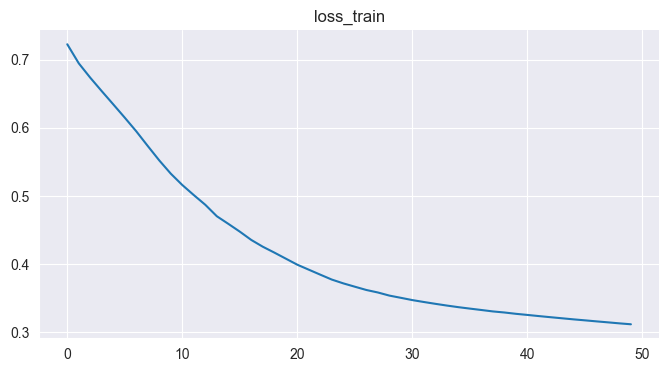

In [15]:
# @title loss_train

from matplotlib import pyplot as plt
df['loss_train'].plot(kind='line', figsize=(8, 4), title='loss_train')
plt.gca().spines[['top', 'right']].set_visible(False)

Text(0.5, 1.0, 'Jaccard test')

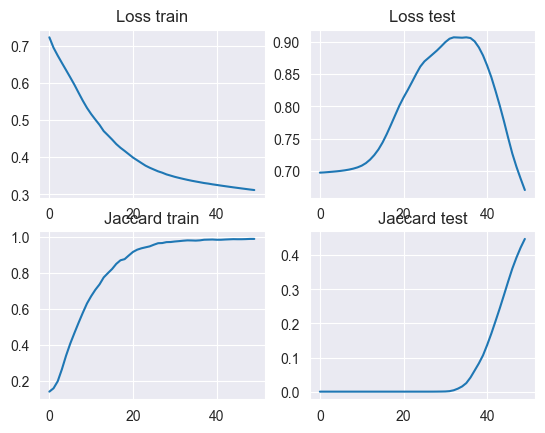

In [16]:
f, axs = plt.subplots(2, 2)
axs[(0,0)].plot(df.loss_train, label="loss_train")
axs[(0,0)].set_title('Loss train')
axs[(0,1)].plot(df.loss_test, label="loss_test")
axs[(0,1)].set_title('Loss test')
axs[(1,0)].plot(df.jac_train, label="jac_train")
axs[(1,0)].set_title('Jaccard train')
axs[(1,1)].plot(df.jac_test, label="jac_test")
axs[(1,1)].set_title('Jaccard test')

Видно что мы переобучились, так как на тестовой выборки лосс заметно выше, чем на тренировочной.
Также индекс Жаккара на тестовой выборке сильно ниже, чем на тренировочной. Мы прекрасно отрабатываем на тренировочной выборке, но на тестовой выборке мы плохо предсказываем маску.

## Полное обучение

In [17]:
train_loader = torch.utils.data.DataLoader(SelfieDataset(train), batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(SelfieDataset(valid), batch_size=1, shuffle=False)

In [18]:
net = UNET(3, 16, 1)
net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

res = train_model(net, optimizer, train_loader, test_loader, epochs = 25, checkpath="unet.pth")


epoch: 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6215, Loss test: 0.7328, Jaccard train: 0.4671, Jaccard test: 0.0000
epoch: 1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.4753, Loss test: 0.4080, Jaccard train: 0.7746, Jaccard test: 0.7636
epoch: 2


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.4082, Loss test: 0.3399, Jaccard train: 0.8286, Jaccard test: 0.8402
epoch: 3


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.3714, Loss test: 0.3208, Jaccard train: 0.8567, Jaccard test: 0.8667
epoch: 4


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.3415, Loss test: 0.3041, Jaccard train: 0.8802, Jaccard test: 0.8834
epoch: 5


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.3177, Loss test: 0.3184, Jaccard train: 0.8945, Jaccard test: 0.8761
epoch: 6


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2973, Loss test: 0.2918, Jaccard train: 0.9063, Jaccard test: 0.8941
epoch: 7


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2799, Loss test: 0.2861, Jaccard train: 0.9141, Jaccard test: 0.8933
epoch: 8


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2611, Loss test: 0.2814, Jaccard train: 0.9248, Jaccard test: 0.9035
epoch: 9


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2453, Loss test: 0.2646, Jaccard train: 0.9318, Jaccard test: 0.8936
epoch: 10


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2314, Loss test: 0.2487, Jaccard train: 0.9366, Jaccard test: 0.9072
epoch: 11


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2173, Loss test: 0.2384, Jaccard train: 0.9424, Jaccard test: 0.9163
epoch: 12


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2065, Loss test: 0.2214, Jaccard train: 0.9441, Jaccard test: 0.9196
epoch: 13


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1928, Loss test: 0.2104, Jaccard train: 0.9522, Jaccard test: 0.9233
epoch: 14


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1792, Loss test: 0.2078, Jaccard train: 0.9586, Jaccard test: 0.9271
epoch: 15


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1689, Loss test: 0.1963, Jaccard train: 0.9624, Jaccard test: 0.9250
epoch: 16


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1583, Loss test: 0.1908, Jaccard train: 0.9662, Jaccard test: 0.9284
epoch: 17


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1485, Loss test: 0.1860, Jaccard train: 0.9704, Jaccard test: 0.9215
epoch: 18


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1408, Loss test: 0.1783, Jaccard train: 0.9711, Jaccard test: 0.9302
epoch: 19


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1330, Loss test: 0.1724, Jaccard train: 0.9733, Jaccard test: 0.9296
epoch: 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1260, Loss test: 0.1673, Jaccard train: 0.9746, Jaccard test: 0.9323
epoch: 21


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1205, Loss test: 0.1645, Jaccard train: 0.9746, Jaccard test: 0.9306
epoch: 22


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1149, Loss test: 0.1638, Jaccard train: 0.9755, Jaccard test: 0.9290
epoch: 23


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1097, Loss test: 0.1598, Jaccard train: 0.9760, Jaccard test: 0.9283
epoch: 24


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1060, Loss test: 0.1513, Jaccard train: 0.9751, Jaccard test: 0.9313
Best epoch: 24


In [19]:
df = pd.DataFrame(res)
df

loss_train  loss_test  jac_train  jac_test
0     0.621507   0.732813   0.467120  0.000000
1     0.475254   0.408014   0.774626  0.763633
2     0.408164   0.339925   0.828560  0.840225
3     0.371414   0.320830   0.856736  0.866719
4     0.341518   0.304127   0.880186  0.883439
5     0.317669   0.318376   0.894538  0.876105
6     0.297350   0.291848   0.906322  0.894135
7     0.279920   0.286100   0.914076  0.893287
8     0.261108   0.281442   0.924803  0.903500
9     0.245334   0.264578   0.931759  0.893632
10    0.231421   0.248743   0.936643  0.907198
11    0.217276   0.238358   0.942410  0.916306
12    0.206528   0.221356   0.944054  0.919580
13    0.192775   0.210423   0.952195  0.923258
14    0.179243   0.207782   0.958604  0.927121
15    0.168894   0.196348   0.962395  0.925016
16    0.158295   0.190770   0.966193  0.928407
17    0.148501   0.185989   0.970391  0.921457
18    0.140798   0.178342   0.971076  0.930185
19    0.132965   0.172352   0.973268  0.929643
20    0.125963   0.167336   0.974580  0.932256
21    0.120484   0.164509   0.974580  0.930596
22    0.114923   0.163786   0.975521  0.928993
23    0.109690   0.159809   0.976002  0.928305
24    0.105999   0.151330   0.975111  0.931288

Text(0.5, 1.0, 'Jaccard test')

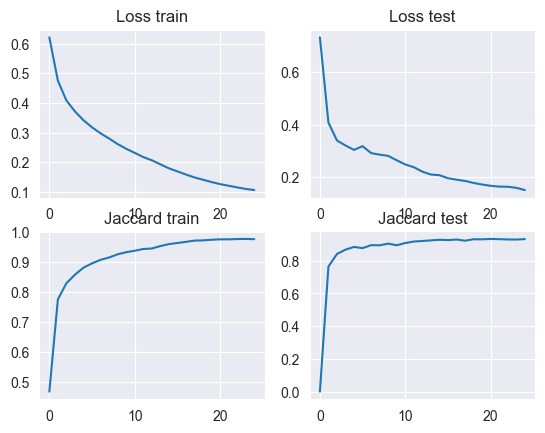

In [20]:
f, axs = plt.subplots(2, 2)
axs[(0,0)].plot(df.loss_train, label="loss_train")
axs[(0,0)].set_title('Loss train')
axs[(0,1)].plot(df.loss_test, label="loss_test")
axs[(0,1)].set_title('Loss test')
axs[(1,0)].plot(df.jac_train, label="jac_train")
axs[(1,0)].set_title('Jaccard train')
axs[(1,1)].plot(df.jac_test, label="jac_test")
axs[(1,1)].set_title('Jaccard test')

In [21]:
# clear cuda memory
del net

In [22]:
torch.cuda.empty_cache()

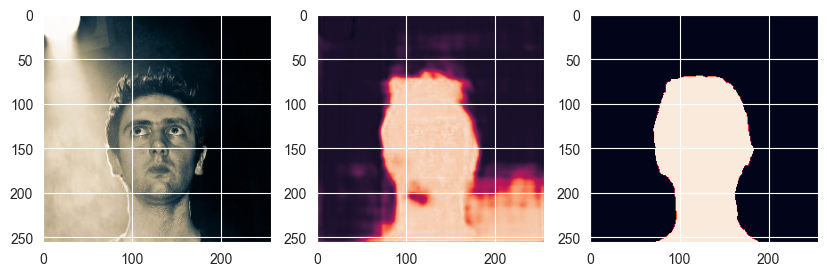

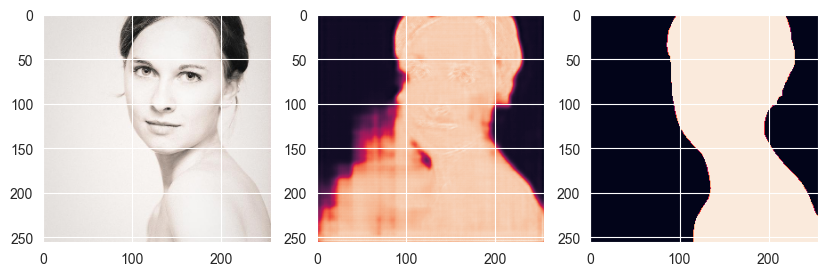

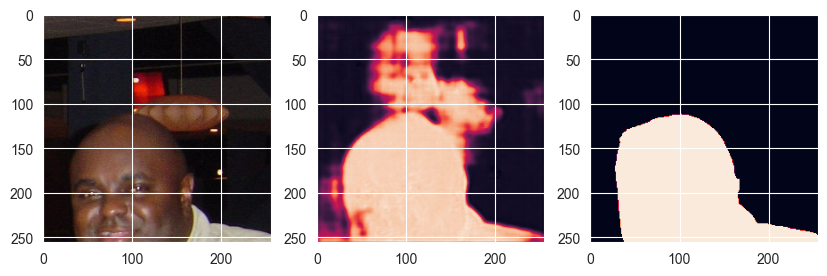

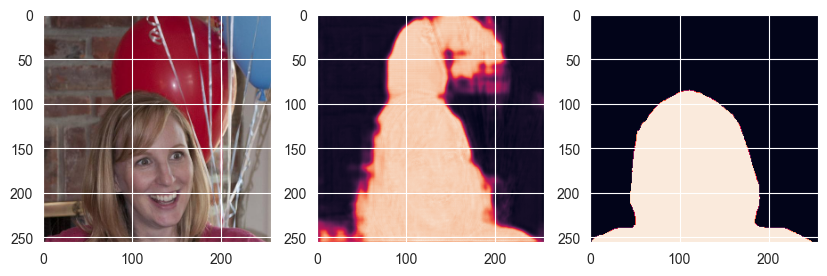

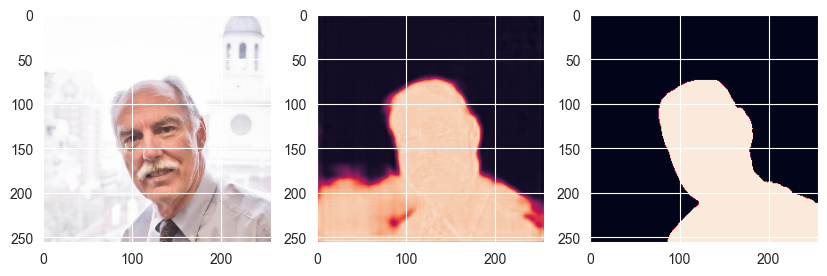

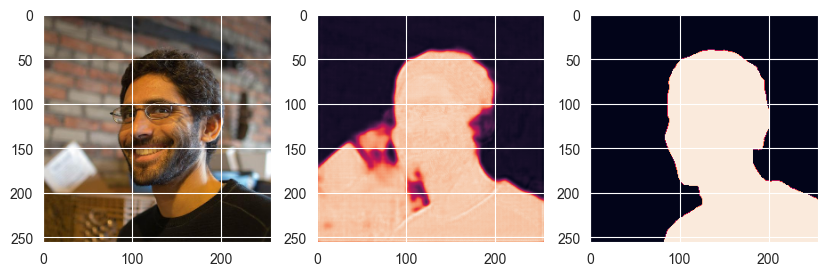

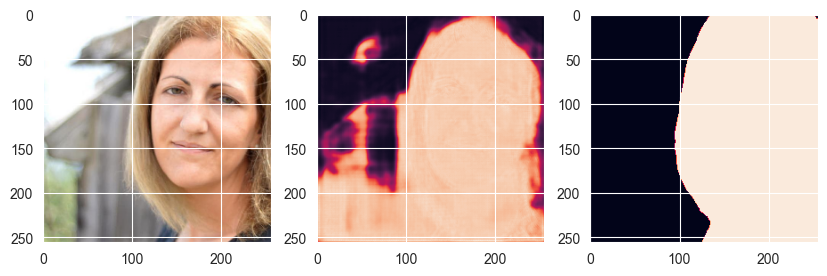

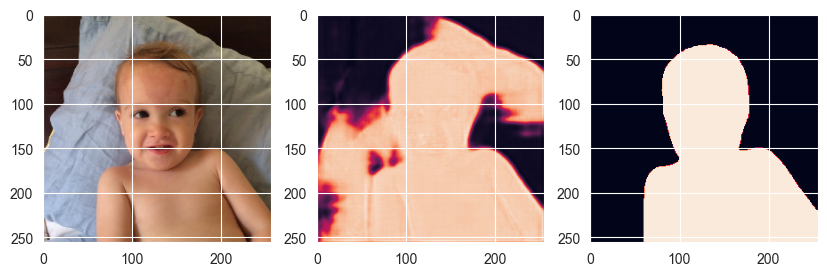

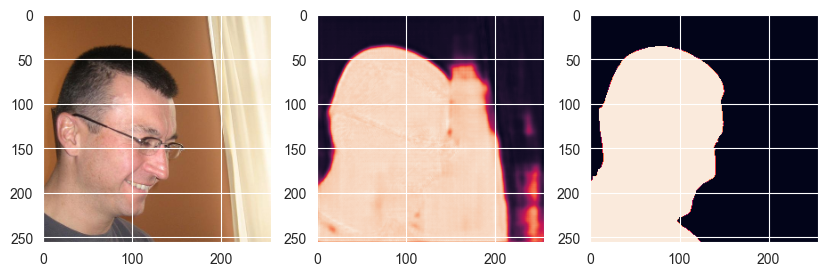

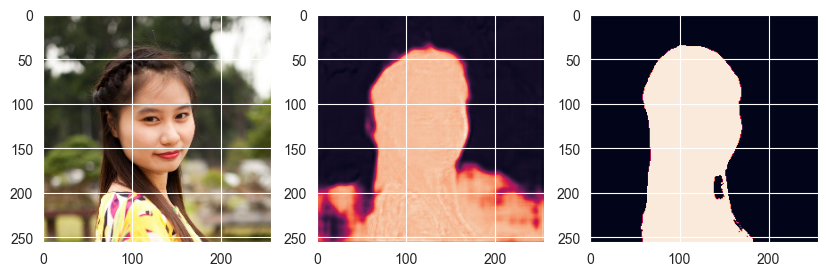

In [35]:

net = UNET(3, 16, 1)
#load model
net.load_state_dict(torch.load("unet.pth"))
net.cuda().eval()

with torch.no_grad():
    jac = []
    for i , (data) in enumerate(valid_loader):
        x_tensor = data['image'].cuda().unsqueeze(0)[0]
        y = data['mask']
        pred = net(x_tensor)
        jac.append((jaccard(pred.cpu(), y).item(), i))
    
    jac = sorted(jac, key=lambda x: x[0])
    idx = [x[1] for x in jac[:10]]
    for i, data in enumerate(valid_loader):
        if i in idx:
            x = data['image']
            y = data['mask']
            pred = net(x.cuda().unsqueeze(0)[0]).cpu()
            _, axs = plt.subplots(1, 3, figsize=(10, 10))
            axs[0].imshow(x[0].cpu().permute(1, 2, 0).numpy())
            axs[1].imshow(pred[0][0].detach().cpu().numpy())
            axs[2].imshow(y[0][0].detach().cpu().numpy())
            plt.show()

        
        
        


Так и не разобрался почему половина изображений отображается в негативе, но это не мешает оценить качество работы модели.
Видно, что на некоторых изображениях модель добавляет в предсказание лишние области.

## Улучшения без изменения архитектуры

### Добавление аугментаций

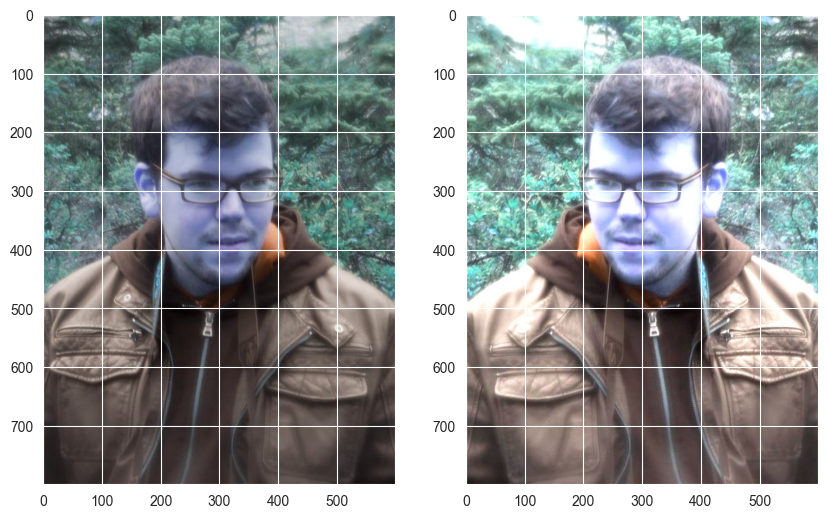

In [38]:
aug_path = "..\\..\\data\\dataset\\augmented"
sourxr = "..\\..\\data\\dataset"
# augment photos and save them 
# 
# def augment_images(imgs_list):
#     for img_path in tqdm(imgs_list):
#         img = cv2.imread(img_path)
#         mask_path = img_path.split("\\")
#         mask_path[-2] = "masks"
#         mask_path[-1] = mask_path[-1][:-4] + ".png"
#         mask_path = "\\".join(mask_path)
#         mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
#         # mirrored and change brightness and contrast
#         img_mirrored = cv2.flip(img, 1)
#         mask_mirrored = cv2.flip(mask, 1)
#         img_mirrored = cv2.convertScaleAbs(img_mirrored, alpha=1.5, beta=0)
#         cv2.imwrite(f"{aug_path}\\images\\{Path(img_path).name[:-4]}_mirrored.jpg", img_mirrored)
#         cv2.imwrite(f"{aug_path}\\masks\\{Path(mask_path).name[:-4]}_mirrored.png", mask_mirrored)
# 
# augment_images(imgs_list)

old_img = cv2.imread("..\\..\\data\\dataset\\images\\1803260459-00000416.jpg")
new_img = cv2.imread("..\\..\\data\\dataset\\augmented\\images\\1803260459-00000416_mirrored.jpg")
_, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(old_img)
axs[1].imshow(new_img)

In [39]:
aug_imgs_list = glob("..\\..\\data\\dataset\\augmented\\images\\*")
all_imgs = imgs_list + aug_imgs_list
train_aug , test_aug = train_test_split(all_imgs, test_size=0.2, random_state=SEED)
train_aug, valid_aug = train_test_split(train_aug, test_size=0.2, random_state=SEED)

train_loader_aug = torch.utils.data.DataLoader(SelfieDataset(train_aug), batch_size=64, shuffle=True)
valid_loader_aug = torch.utils.data.DataLoader(SelfieDataset(valid_aug), batch_size=1, shuffle=False)
test_loader_aug = torch.utils.data.DataLoader(SelfieDataset(test_aug), batch_size=64, shuffle=False)

In [40]:
del net
torch.cuda.empty_cache()


In [41]:
net = UNET(3, 16, 1)
net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

res = train_model(net, optimizer, train_loader_aug, test_loader_aug, epochs = 25, checkpath="unet_aug.pth")


epoch: 0


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.5404, Loss test: 0.3702, Jaccard train: 0.6546, Jaccard test: 0.7624
epoch: 1


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.3650, Loss test: 0.3338, Jaccard train: 0.8296, Jaccard test: 0.8454
epoch: 2


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.3108, Loss test: 0.2966, Jaccard train: 0.8693, Jaccard test: 0.8706
epoch: 3


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.2719, Loss test: 0.2832, Jaccard train: 0.8917, Jaccard test: 0.8667
epoch: 4


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.2418, Loss test: 0.2455, Jaccard train: 0.9065, Jaccard test: 0.8948
epoch: 5


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.2151, Loss test: 0.2222, Jaccard train: 0.9188, Jaccard test: 0.9083
epoch: 6


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.1911, Loss test: 0.2211, Jaccard train: 0.9311, Jaccard test: 0.8911
epoch: 7


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.1715, Loss test: 0.1807, Jaccard train: 0.9386, Jaccard test: 0.9194
epoch: 8


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.1546, Loss test: 0.1717, Jaccard train: 0.9447, Jaccard test: 0.9231
epoch: 9


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.1388, Loss test: 0.1611, Jaccard train: 0.9510, Jaccard test: 0.9236
epoch: 10


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.1266, Loss test: 0.1588, Jaccard train: 0.9550, Jaccard test: 0.9206
epoch: 11


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss train: 0.1134, Loss test: 0.1608, Jaccard train: 0.9608, Jaccard test: 0.9191
epoch: 12


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.1063, Loss test: 0.1530, Jaccard train: 0.9607, Jaccard test: 0.9138
epoch: 13


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.0956, Loss test: 0.1326, Jaccard train: 0.9658, Jaccard test: 0.9346
epoch: 14


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.0864, Loss test: 0.1279, Jaccard train: 0.9697, Jaccard test: 0.9322
epoch: 15


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.0822, Loss test: 0.1202, Jaccard train: 0.9691, Jaccard test: 0.9370
epoch: 16


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss train: 0.0760, Loss test: 0.1256, Jaccard train: 0.9713, Jaccard test: 0.9296
epoch: 17


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.0696, Loss test: 0.1170, Jaccard train: 0.9737, Jaccard test: 0.9369
epoch: 18


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.0633, Loss test: 0.1115, Jaccard train: 0.9766, Jaccard test: 0.9386
epoch: 19


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.0587, Loss test: 0.1087, Jaccard train: 0.9781, Jaccard test: 0.9406
epoch: 20


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.0555, Loss test: 0.1060, Jaccard train: 0.9786, Jaccard test: 0.9427
epoch: 21


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss train: 0.0553, Loss test: 0.1128, Jaccard train: 0.9767, Jaccard test: 0.9332
epoch: 22


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss train: 0.0518, Loss test: 0.1083, Jaccard train: 0.9779, Jaccard test: 0.9377
epoch: 23


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Model saved
Loss train: 0.0486, Loss test: 0.1032, Jaccard train: 0.9791, Jaccard test: 0.9414
epoch: 24


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Loss train: 0.0469, Loss test: 0.1047, Jaccard train: 0.9792, Jaccard test: 0.9393
Best epoch: 23


In [42]:
df = pd.DataFrame(res)
df

loss_train  loss_test  jac_train  jac_test
0     0.540410   0.370235   0.654621  0.762380
1     0.364954   0.333795   0.829574  0.845357
2     0.310838   0.296620   0.869301  0.870617
3     0.271862   0.283200   0.891735  0.866678
4     0.241803   0.245515   0.906478  0.894789
5     0.215143   0.222172   0.918760  0.908345
6     0.191066   0.221096   0.931081  0.891138
7     0.171486   0.180721   0.938573  0.919433
8     0.154557   0.171743   0.944652  0.923105
9     0.138809   0.161132   0.951032  0.923600
10    0.126553   0.158777   0.955000  0.920631
11    0.113408   0.160798   0.960845  0.919148
12    0.106303   0.153038   0.960711  0.913823
13    0.095628   0.132640   0.965797  0.934568
14    0.086410   0.127871   0.969707  0.932234
15    0.082213   0.120246   0.969051  0.937015
16    0.076007   0.125627   0.971278  0.929592
17    0.069646   0.116988   0.973683  0.936868
18    0.063269   0.111537   0.976635  0.938643
19    0.058745   0.108701   0.978059  0.940561
20    0.055472   0.105958   0.978574  0.942652
21    0.055308   0.112812   0.976701  0.933214
22    0.051821   0.108306   0.977904  0.937671
23    0.048594   0.103155   0.979124  0.941440
24    0.046887   0.104722   0.979234  0.939324

Text(0.5, 1.0, 'Jaccard test')

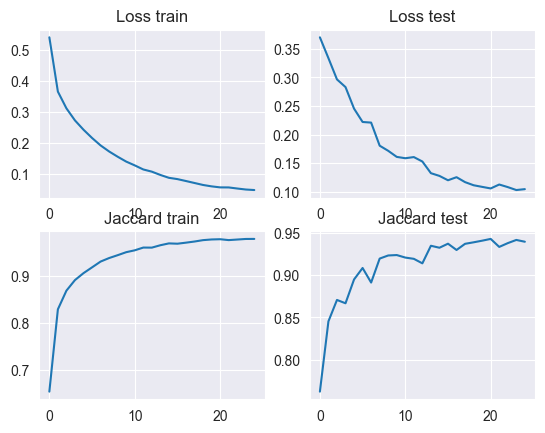

In [43]:
f, axs = plt.subplots(2, 2)
axs[(0,0)].plot(df.loss_train, label="loss_train")
axs[(0,0)].set_title('Loss train')
axs[(0,1)].plot(df.loss_test, label="loss_test")
axs[(0,1)].set_title('Loss test')   
axs[(1,0)].plot(df.jac_train, label="jac_train")
axs[(1,0)].set_title('Jaccard train')
axs[(1,1)].plot(df.jac_test, label="jac_test")
axs[(1,1)].set_title('Jaccard test')


По сравнению с моделью без аугментаций результаты улучшились. Возможно это связано с тем что я изначально не дообучил модель до лучшего результата(тут уж простите, слишком долго обучать). 12 эпоха модели соответствует 25 эпохам модели без аугментаций, что соотносится с увеличением размера датасета в 2 раза. Вероятно, что сама по себе аугментация не дала бы такого улучшения если бы я дообучил модель без аугментации до 50 эпох.

### Гиперпараметры. Подбор

Попробуем использовать разные оптимизаторы с фиксированным learning rate

In [45]:
res_opts = []
for opt in [optim.AdamW, optim.SGD, optim.RMSprop]:
    net = UNET(3, 16, 1)
    net = net.cuda()
    optimizer = opt(net.parameters(), lr=3e-4)
    res_opts.append(train_model(net, optimizer, train_loader, test_loader, epochs = 25, checkpath=f"unet_{opt.__name__}.pth"))


epoch: 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6104, Loss test: 0.6962, Jaccard train: 0.5536, Jaccard test: 0.0547
epoch: 1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.4416, Loss test: 0.4887, Jaccard train: 0.7750, Jaccard test: 0.6030
epoch: 2


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.3668, Loss test: 0.3345, Jaccard train: 0.8348, Jaccard test: 0.8274
epoch: 3


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.3301, Loss test: 0.2961, Jaccard train: 0.8648, Jaccard test: 0.8732
epoch: 4


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.3049, Loss test: 0.2823, Jaccard train: 0.8812, Jaccard test: 0.8849
epoch: 5


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2804, Loss test: 0.2794, Jaccard train: 0.8997, Jaccard test: 0.8933
epoch: 6


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2590, Loss test: 0.2563, Jaccard train: 0.9140, Jaccard test: 0.9011
epoch: 7


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.2421, Loss test: 0.2644, Jaccard train: 0.9229, Jaccard test: 0.8906
epoch: 8


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2273, Loss test: 0.2390, Jaccard train: 0.9301, Jaccard test: 0.9061
epoch: 9


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.2154, Loss test: 0.2503, Jaccard train: 0.9333, Jaccard test: 0.8784
epoch: 10


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2028, Loss test: 0.2221, Jaccard train: 0.9384, Jaccard test: 0.9074
epoch: 11


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1875, Loss test: 0.2077, Jaccard train: 0.9485, Jaccard test: 0.9201
epoch: 12


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1771, Loss test: 0.2016, Jaccard train: 0.9522, Jaccard test: 0.9196
epoch: 13


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1665, Loss test: 0.1949, Jaccard train: 0.9558, Jaccard test: 0.9218
epoch: 14


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1569, Loss test: 0.1835, Jaccard train: 0.9595, Jaccard test: 0.9286
epoch: 15


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.1479, Loss test: 0.1868, Jaccard train: 0.9631, Jaccard test: 0.9231
epoch: 16


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1416, Loss test: 0.1698, Jaccard train: 0.9633, Jaccard test: 0.9301
epoch: 17


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.1316, Loss test: 0.1747, Jaccard train: 0.9684, Jaccard test: 0.9246
epoch: 18


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.1261, Loss test: 0.1701, Jaccard train: 0.9684, Jaccard test: 0.9203
epoch: 19


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1202, Loss test: 0.1597, Jaccard train: 0.9699, Jaccard test: 0.9245
epoch: 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1137, Loss test: 0.1547, Jaccard train: 0.9717, Jaccard test: 0.9300
epoch: 21


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1071, Loss test: 0.1458, Jaccard train: 0.9743, Jaccard test: 0.9365
epoch: 22


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1027, Loss test: 0.1410, Jaccard train: 0.9746, Jaccard test: 0.9365
epoch: 23


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.0970, Loss test: 0.1481, Jaccard train: 0.9768, Jaccard test: 0.9279
epoch: 24


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0908, Loss test: 0.1349, Jaccard train: 0.9795, Jaccard test: 0.9383
Best epoch: 24
epoch: 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.7086, Loss test: 0.6922, Jaccard train: 0.3932, Jaccard test: 0.4709
epoch: 1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.7067, Loss test: 0.6959, Jaccard train: 0.3978, Jaccard test: 0.4253
epoch: 2


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.7047, Loss test: 0.6991, Jaccard train: 0.4025, Jaccard test: 0.4090
epoch: 3


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.7027, Loss test: 0.6983, Jaccard train: 0.4079, Jaccard test: 0.4159
epoch: 4


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.7009, Loss test: 0.6966, Jaccard train: 0.4132, Jaccard test: 0.4218
epoch: 5


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.6991, Loss test: 0.6951, Jaccard train: 0.4186, Jaccard test: 0.4260
epoch: 6


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.6969, Loss test: 0.6932, Jaccard train: 0.4249, Jaccard test: 0.4326
epoch: 7


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6952, Loss test: 0.6916, Jaccard train: 0.4302, Jaccard test: 0.4385
epoch: 8


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6935, Loss test: 0.6901, Jaccard train: 0.4365, Jaccard test: 0.4446
epoch: 9


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6923, Loss test: 0.6887, Jaccard train: 0.4410, Jaccard test: 0.4488
epoch: 10


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6905, Loss test: 0.6872, Jaccard train: 0.4472, Jaccard test: 0.4528
epoch: 11


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6890, Loss test: 0.6856, Jaccard train: 0.4526, Jaccard test: 0.4573
epoch: 12


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6876, Loss test: 0.6842, Jaccard train: 0.4575, Jaccard test: 0.4613
epoch: 13


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6857, Loss test: 0.6830, Jaccard train: 0.4627, Jaccard test: 0.4666
epoch: 14


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6844, Loss test: 0.6820, Jaccard train: 0.4664, Jaccard test: 0.4705
epoch: 15


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6828, Loss test: 0.6805, Jaccard train: 0.4706, Jaccard test: 0.4739
epoch: 16


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6817, Loss test: 0.6794, Jaccard train: 0.4739, Jaccard test: 0.4782
epoch: 17


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6802, Loss test: 0.6784, Jaccard train: 0.4776, Jaccard test: 0.4806
epoch: 18


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6791, Loss test: 0.6771, Jaccard train: 0.4798, Jaccard test: 0.4829
epoch: 19


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6780, Loss test: 0.6759, Jaccard train: 0.4825, Jaccard test: 0.4849
epoch: 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6768, Loss test: 0.6750, Jaccard train: 0.4845, Jaccard test: 0.4873
epoch: 21


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6754, Loss test: 0.6739, Jaccard train: 0.4869, Jaccard test: 0.4898
epoch: 22


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6743, Loss test: 0.6728, Jaccard train: 0.4891, Jaccard test: 0.4920
epoch: 23


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6735, Loss test: 0.6717, Jaccard train: 0.4902, Jaccard test: 0.4936
epoch: 24


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.6720, Loss test: 0.6711, Jaccard train: 0.4927, Jaccard test: 0.4954
Best epoch: 24
epoch: 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.5953, Loss test: 0.7873, Jaccard train: 0.5074, Jaccard test: 0.0045
epoch: 1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.4274, Loss test: 0.3887, Jaccard train: 0.7191, Jaccard test: 0.7324
epoch: 2


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.3483, Loss test: 0.3702, Jaccard train: 0.7936, Jaccard test: 0.7602
epoch: 3


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.3062, Loss test: 0.3023, Jaccard train: 0.8253, Jaccard test: 0.8182
epoch: 4


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2767, Loss test: 0.2804, Jaccard train: 0.8483, Jaccard test: 0.8389
epoch: 5


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2540, Loss test: 0.2531, Jaccard train: 0.8646, Jaccard test: 0.8664
epoch: 6


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2342, Loss test: 0.2447, Jaccard train: 0.8781, Jaccard test: 0.8562
epoch: 7


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2143, Loss test: 0.2144, Jaccard train: 0.8930, Jaccard test: 0.8878
epoch: 8


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2017, Loss test: 0.2021, Jaccard train: 0.8994, Jaccard test: 0.8990
epoch: 9


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1885, Loss test: 0.1953, Jaccard train: 0.9067, Jaccard test: 0.9040
epoch: 10


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1792, Loss test: 0.1845, Jaccard train: 0.9102, Jaccard test: 0.9080
epoch: 11


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1652, Loss test: 0.1714, Jaccard train: 0.9220, Jaccard test: 0.9172
epoch: 12


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1517, Loss test: 0.1655, Jaccard train: 0.9308, Jaccard test: 0.9116
epoch: 13


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.1453, Loss test: 0.1688, Jaccard train: 0.9324, Jaccard test: 0.9090
epoch: 14


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1368, Loss test: 0.1493, Jaccard train: 0.9366, Jaccard test: 0.9280
epoch: 15


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1307, Loss test: 0.1410, Jaccard train: 0.9394, Jaccard test: 0.9284
epoch: 16


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.1235, Loss test: 0.1440, Jaccard train: 0.9426, Jaccard test: 0.9219
epoch: 17


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1179, Loss test: 0.1295, Jaccard train: 0.9448, Jaccard test: 0.9328
epoch: 18


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1078, Loss test: 0.1278, Jaccard train: 0.9510, Jaccard test: 0.9335
epoch: 19


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.0980, Loss test: 0.1328, Jaccard train: 0.9582, Jaccard test: 0.9276
epoch: 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0956, Loss test: 0.1228, Jaccard train: 0.9575, Jaccard test: 0.9328
epoch: 21


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0904, Loss test: 0.1145, Jaccard train: 0.9595, Jaccard test: 0.9384
epoch: 22


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.0838, Loss test: 0.1250, Jaccard train: 0.9634, Jaccard test: 0.9279
epoch: 23


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0965, Loss test: 0.1120, Jaccard train: 0.9496, Jaccard test: 0.9335
epoch: 24


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0773, Loss test: 0.1074, Jaccard train: 0.9652, Jaccard test: 0.9407
Best epoch: 24


In [51]:
df_opts = [pd.DataFrame(res) for res in res_opts]  
df_opts[0]


loss_train  loss_test  jac_train  jac_test
0     0.610380   0.696184   0.553621  0.054683
1     0.441601   0.488654   0.775042  0.603021
2     0.366826   0.334461   0.834798  0.827423
3     0.330073   0.296137   0.864838  0.873195
4     0.304893   0.282262   0.881230  0.884875
5     0.280434   0.279419   0.899716  0.893257
6     0.259047   0.256303   0.913954  0.901057
7     0.242099   0.264401   0.922900  0.890557
8     0.227267   0.239027   0.930076  0.906063
9     0.215350   0.250267   0.933344  0.878410
10    0.202832   0.222082   0.938363  0.907397
11    0.187514   0.207724   0.948454  0.920077
12    0.177123   0.201648   0.952197  0.919595
13    0.166502   0.194869   0.955809  0.921840
14    0.156862   0.183543   0.959493  0.928602
15    0.147930   0.186763   0.963140  0.923083
16    0.141607   0.169847   0.963313  0.930104
17    0.131609   0.174725   0.968448  0.924555
18    0.126108   0.170080   0.968441  0.920330
19    0.120154   0.159719   0.969871  0.924479
20    0.113733   0.154653   0.971669  0.930004
21    0.107069   0.145811   0.974294  0.936518
22    0.102678   0.141025   0.974639  0.936470
23    0.097046   0.148078   0.976812  0.927894
24    0.090839   0.134875   0.979547  0.938264

In [52]:
df_opts[1]

loss_train  loss_test  jac_train  jac_test
0     0.708592   0.692188   0.393216  0.470904
1     0.706710   0.695885   0.397757  0.425321
2     0.704706   0.699146   0.402538  0.409020
3     0.702655   0.698348   0.407874  0.415897
4     0.700942   0.696574   0.413154  0.421833
5     0.699068   0.695052   0.418580  0.425985
6     0.696912   0.693173   0.424919  0.432574
7     0.695156   0.691616   0.430213  0.438463
8     0.693544   0.690107   0.436497  0.444591
9     0.692251   0.688708   0.441009  0.448849
10    0.690535   0.687245   0.447195  0.452827
11    0.688980   0.685603   0.452597  0.457319
12    0.687558   0.684188   0.457509  0.461297
13    0.685657   0.683000   0.462658  0.466570
14    0.684434   0.681983   0.466426  0.470462
15    0.682836   0.680470   0.470574  0.473876
16    0.681722   0.679441   0.473864  0.478207
17    0.680181   0.678375   0.477589  0.480594
18    0.679091   0.677126   0.479770  0.482917
19    0.677991   0.675899   0.482479  0.484944
20    0.676778   0.674983   0.484451  0.487309
21    0.675426   0.673889   0.486855  0.489758
22    0.674333   0.672838   0.489126  0.491979
23    0.673478   0.671659   0.490212  0.493644
24    0.672015   0.671094   0.492671  0.495418

In [53]:
df_opts[2]

loss_train  loss_test  jac_train  jac_test
0     0.595332   0.787272   0.507424  0.004461
1     0.427433   0.388735   0.719053  0.732363
2     0.348324   0.370184   0.793587  0.760236
3     0.306171   0.302313   0.825331  0.818176
4     0.276736   0.280376   0.848310  0.838929
5     0.254033   0.253147   0.864560  0.866351
6     0.234203   0.244669   0.878088  0.856231
7     0.214317   0.214406   0.892997  0.887763
8     0.201683   0.202110   0.899359  0.898989
9     0.188515   0.195262   0.906670  0.903996
10    0.179240   0.184456   0.910208  0.907961
11    0.165249   0.171364   0.922023  0.917165
12    0.151688   0.165484   0.930805  0.911612
13    0.145269   0.168836   0.932409  0.909001
14    0.136820   0.149298   0.936555  0.927957
15    0.130740   0.140989   0.939394  0.928363
16    0.123503   0.144012   0.942605  0.921909
17    0.117861   0.129467   0.944794  0.932770
18    0.107815   0.127807   0.951028  0.933550
19    0.098043   0.132844   0.958220  0.927637
20    0.095582   0.122785   0.957462  0.932849
21    0.090355   0.114511   0.959492  0.938353
22    0.083772   0.124967   0.963437  0.927855
23    0.096550   0.111988   0.949605  0.933546
24    0.077262   0.107400   0.965246  0.940663

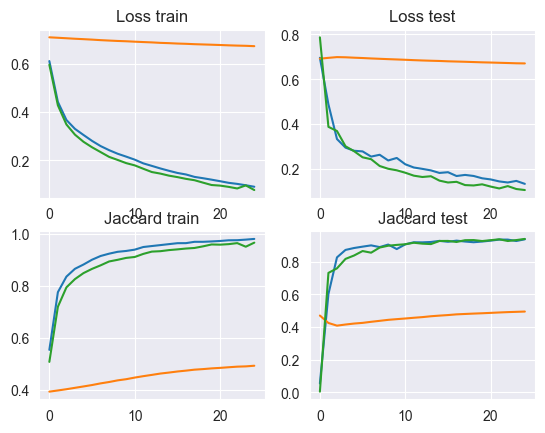

In [49]:
# Построим графики которые покажут какой оптимизатор лучше. Зеленый - RMSProp, синий - AdamW, оранжевый - RMSprop
f, axs = plt.subplots(2, 2)

for i, res in enumerate(res_opts):
    axs[(0,0)].plot(res['loss_train'], label=f"loss_train_{['SGD', 'Adam', 'RMSprop'][i]}")
    axs[(0,0)].set_title('Loss train')
    axs[(0,1)].plot(res['loss_test'], label=f"loss_test_{['SGD', 'Adam', 'RMSprop'][i]}")
    axs[(0,1)].set_title('Loss test')
    axs[(1,0)].plot(res['jac_train'], label=f"jac_train_{['SGD', 'Adam', 'RMSprop'][i]}")
    axs[(1,0)].set_title('Jaccard train')
    axs[(1,1)].plot(res['jac_test'], label=f"jac_test_{['SGD', 'Adam', 'RMSprop'][i]}")
    axs[(1,1)].set_title('Jaccard test')

    

Лучше всего показал себя алгоритм RMSprop. Его ошибка оказалась примерно на 3 процента ниже, чем AdamW и на ~5 процентов лучше Adam. Хуже всего себя показал SGD. 

### Test time

Попробуем применить test time аугментацию через horizontal flip

Jaccard index aug: 0.6954019665718079
Jaccard index: 0.6888076663017273


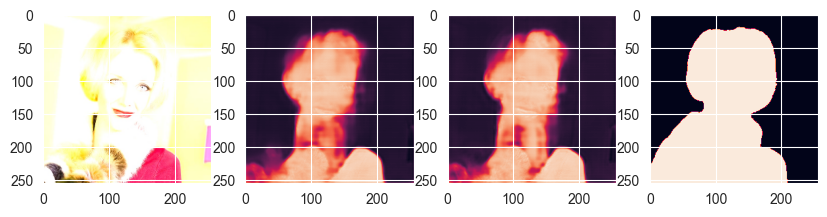

Jaccard index aug: 0.6677086353302002
Jaccard index: 0.5775129795074463


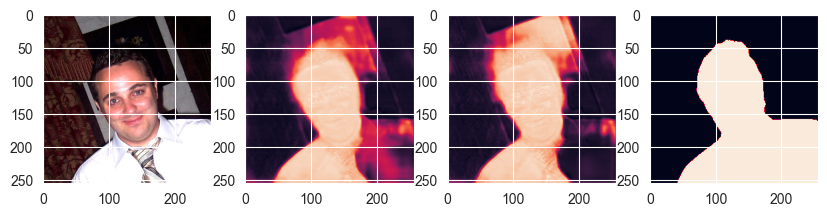

Jaccard index aug: 0.7531539797782898
Jaccard index: 0.7446311712265015


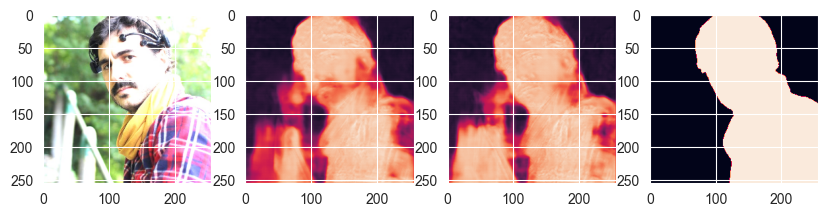

Jaccard index aug: 0.7788735628128052
Jaccard index: 0.6918841600418091


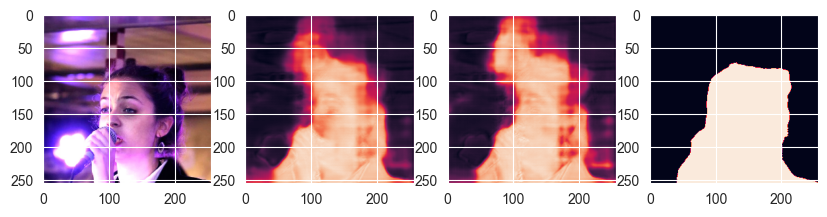

Jaccard index aug: 0.7359701991081238
Jaccard index: 0.6467381119728088


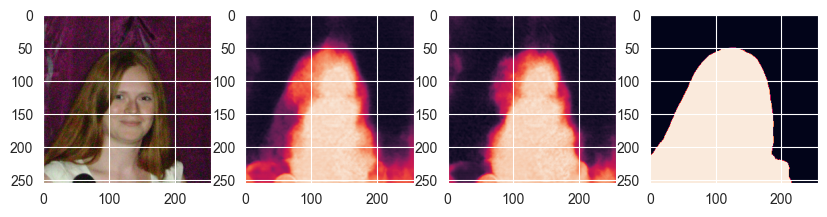

Jaccard index aug: 0.7601768374443054
Jaccard index: 0.6519833207130432


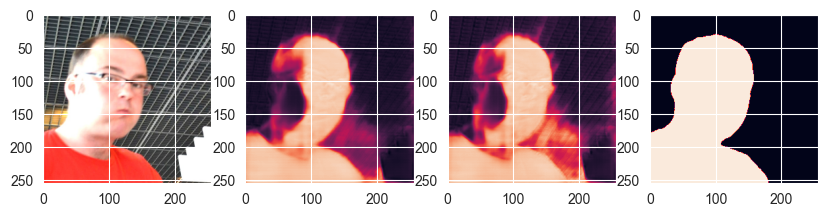

Jaccard index aug: 0.7644749283790588
Jaccard index: 0.738276481628418


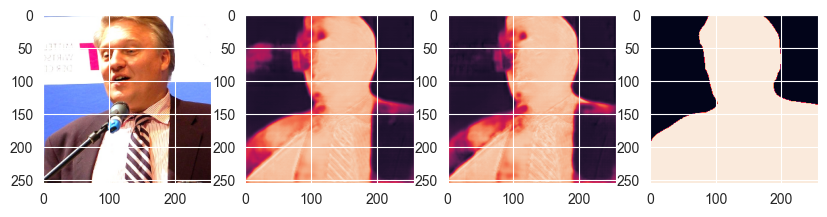

Jaccard index aug: 0.7705072164535522
Jaccard index: 0.6021310091018677


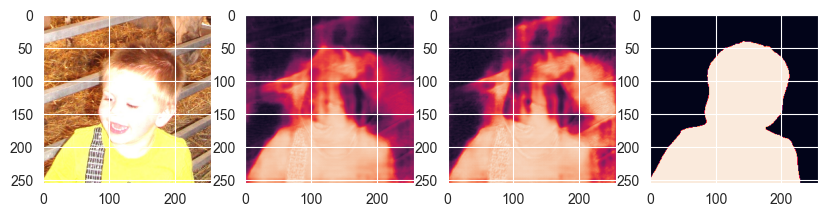

Jaccard index aug: 0.7446219325065613
Jaccard index: 0.6988810300827026


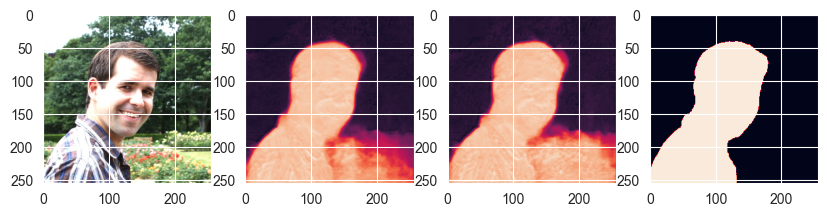

Jaccard index aug: 0.7038626670837402
Jaccard index: 0.7073008418083191


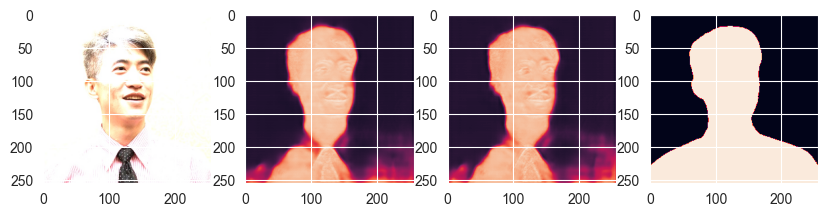

In [57]:
# load RMSprop model

net = UNET(3, 16, 1)
net.load_state_dict(torch.load("unet_RMSprop.pth"))
net.cuda().eval()

#calculate jaccard index
with torch.no_grad():
    jac = []
    for i , (data) in enumerate(valid_loader_aug):
        x_tensor = data['image'].cuda().unsqueeze(0)[0]
        y = data['mask']
        pred = net(x_tensor)
        jac.append((jaccard(pred.cpu(), y).item(), i))
    
    jac = sorted(jac, key=lambda x: x[0])
    idx = [x[1] for x in jac[:10]]
    for i, data in enumerate(valid_loader_aug):
        if i in idx:
            x = data['image']
            y = data['mask']
            x_mirrored = functional.hflip(x)
            pred = net(x.cuda().unsqueeze(0)[0]).cpu()
            pred_mirrored = net(x_mirrored.cuda().unsqueeze(0)[0]).cpu()
            # mean of two predictions
            pred_res = (pred + functional.hflip(pred_mirrored)) / 2
            _, axs = plt.subplots(1, 4, figsize=(10, 15))
            axs[0].imshow(x[0].cpu().permute(1, 2, 0).numpy())
            axs[1].imshow(pred_res[0][0].detach().cpu().numpy())
            axs[2].imshow(pred[0][0].detach().cpu().numpy())
            axs[3].imshow(y[0][0].detach().cpu().numpy())
            #count jaccard index
            print(f'Jaccard index aug: {jaccard(pred_res, y).item()}')
            print(f'Jaccard index: {jaccard(pred, y).item()}')
            plt.show()

Как визуально на некоторых изображениях, так и по индексу Жаккара видно, что test time аугментация улучшает качество предсказания.
На некоторых изображениях улучшение составляет 5 процентов.

## Улучшение модели с изменением архитектуры

Добавим в нижний слой Unet больше сверток

In [63]:
class Modified_encoder(nn.Module): 
    def __init__(self, in_channels, out_channels, padding, n_down=4, n_conv_lower_layer=4):
        super(Modified_encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        # Increase the number of convolutions in the lower layer
        self.enc_layers.append(CNNBlocks(n_conv=n_conv_lower_layer, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections
    
class Modified_UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1, n_conv_lower_layer=4, *args,
                 **kwargs):
        super(Modified_UNET, self).__init__()
        super().__init__(*args, **kwargs)
        self.encoder = Modified_encoder(in_channels, first_out_channels, padding=padding, n_down=n_down, n_conv_lower_layer=n_conv_lower_layer)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

In [65]:
net = Modified_UNET(3, 16, 1)
net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

res = train_model(net, optimizer, train_loader, test_loader, epochs = 25, checkpath="unet_modified.pth")    

epoch: 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.5936, Loss test: 0.6546, Jaccard train: 0.6120, Jaccard test: 0.6064
epoch: 1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.4083, Loss test: 0.4278, Jaccard train: 0.8056, Jaccard test: 0.6545
epoch: 2


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.3483, Loss test: 0.3085, Jaccard train: 0.8569, Jaccard test: 0.8562
epoch: 3


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.3143, Loss test: 0.2935, Jaccard train: 0.8850, Jaccard test: 0.8967
epoch: 4


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.2881, Loss test: 0.2962, Jaccard train: 0.9054, Jaccard test: 0.8940
epoch: 5


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2662, Loss test: 0.2671, Jaccard train: 0.9194, Jaccard test: 0.9091
epoch: 6


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2495, Loss test: 0.2608, Jaccard train: 0.9264, Jaccard test: 0.8999
epoch: 7


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2330, Loss test: 0.2463, Jaccard train: 0.9344, Jaccard test: 0.9137
epoch: 8


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2167, Loss test: 0.2377, Jaccard train: 0.9442, Jaccard test: 0.9159
epoch: 9


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2038, Loss test: 0.2243, Jaccard train: 0.9477, Jaccard test: 0.9216
epoch: 10


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1903, Loss test: 0.2107, Jaccard train: 0.9536, Jaccard test: 0.9239
epoch: 11


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1778, Loss test: 0.1998, Jaccard train: 0.9592, Jaccard test: 0.9297
epoch: 12


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1677, Loss test: 0.1988, Jaccard train: 0.9621, Jaccard test: 0.9262
epoch: 13


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1592, Loss test: 0.1874, Jaccard train: 0.9632, Jaccard test: 0.9247
epoch: 14


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.1523, Loss test: 0.2020, Jaccard train: 0.9627, Jaccard test: 0.9048
epoch: 15


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1441, Loss test: 0.1738, Jaccard train: 0.9648, Jaccard test: 0.9304
epoch: 16


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1335, Loss test: 0.1653, Jaccard train: 0.9706, Jaccard test: 0.9334
epoch: 17


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1255, Loss test: 0.1572, Jaccard train: 0.9735, Jaccard test: 0.9410
epoch: 18


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1186, Loss test: 0.1479, Jaccard train: 0.9751, Jaccard test: 0.9421
epoch: 19


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1117, Loss test: 0.1420, Jaccard train: 0.9770, Jaccard test: 0.9460
epoch: 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1047, Loss test: 0.1370, Jaccard train: 0.9798, Jaccard test: 0.9471
epoch: 21


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0994, Loss test: 0.1339, Jaccard train: 0.9807, Jaccard test: 0.9472
epoch: 22


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0934, Loss test: 0.1325, Jaccard train: 0.9826, Jaccard test: 0.9464
epoch: 23


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0892, Loss test: 0.1278, Jaccard train: 0.9829, Jaccard test: 0.9479
epoch: 24


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0857, Loss test: 0.1265, Jaccard train: 0.9827, Jaccard test: 0.9458
Best epoch: 24


In [66]:
# compare with previous AdamW model
df = pd.DataFrame(res)
df

loss_train  loss_test  jac_train  jac_test
0     0.593600   0.654613   0.611969  0.606394
1     0.408323   0.427755   0.805629  0.654453
2     0.348344   0.308520   0.856932  0.856188
3     0.314266   0.293511   0.884990  0.896747
4     0.288065   0.296227   0.905445  0.893973
5     0.266236   0.267068   0.919440  0.909055
6     0.249537   0.260827   0.926446  0.899890
7     0.232979   0.246265   0.934390  0.913739
8     0.216707   0.237662   0.944219  0.915918
9     0.203815   0.224315   0.947737  0.921631
10    0.190321   0.210713   0.953639  0.923911
11    0.177787   0.199760   0.959237  0.929736
12    0.167667   0.198783   0.962136  0.926245
13    0.159191   0.187391   0.963239  0.924705
14    0.152287   0.202023   0.962724  0.904767
15    0.144143   0.173843   0.964827  0.930411
16    0.133508   0.165306   0.970564  0.933386
17    0.125468   0.157213   0.973476  0.940954
18    0.118571   0.147912   0.975060  0.942141
19    0.111713   0.142008   0.977025  0.946027
20    0.104680   0.137008   0.979771  0.947074
21    0.099383   0.133856   0.980654  0.947250
22    0.093445   0.132512   0.982617  0.946425
23    0.089234   0.127777   0.982901  0.947879
24    0.085653   0.126490   0.982747  0.945805

Text(0.5, 1.0, 'Jaccard test')

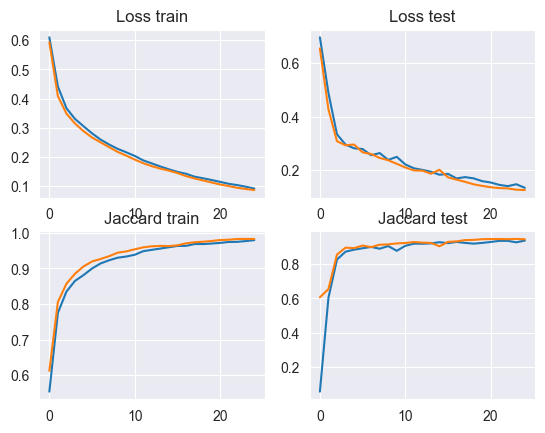

In [70]:
# draw losses of models on one plot
f, axs = plt.subplots(2, 2)
axs[(0,0)].plot(df_opts[0].loss_train, label="loss_train_AdamW")
axs[(0,0)].plot(df.loss_train, label="loss_train_modified") 
axs[(0,0)].set_title('Loss train')
axs[(0,1)].plot(df_opts[0].loss_test, label="loss_test_AdamW")
axs[(0,1)].plot(df.loss_test, label="loss_test_modified")
axs[(0,1)].set_title('Loss test')
axs[(1,0)].plot(df_opts[0].jac_train, label="jac_train_AdamW")
axs[(1,0)].plot(df.jac_train, label="jac_train_modified")
axs[(1,0)].set_title('Jaccard train')
axs[(1,1)].plot(df_opts[0].jac_test, label="jac_test_AdamW")
axs[(1,1)].plot(df.jac_test, label="jac_test_modified")
axs[(1,1)].set_title('Jaccard test')

Синий график - модель с изменениями, оранжевый - модель без изменений(AdamW).
Добавление сверток в нижний слой Unet заметно улучшило качество модели(для уровня в 88 процентов точности это неплохо). Ошибка на тестовой выборке уменьшилась на .8 процента по сравнению с AdamW моделью и на 2.5 процента по сравнению с моделью без изменений с оптимизатором Adam.

## ResNet pretrained

In [80]:
# Используем предобученный энкодер ResNet50

import segmentation_models_pytorch as smp

model = smp.Unet("resnet18", encoder_weights="imagenet")
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [81]:
res_resnet = train_model(model, optimizer, train_loader, test_loader, epochs = 25, checkpath="unet_resnet.pth")


epoch: 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.4541, Loss test: 0.2564, Jaccard train: 0.7062, Jaccard test: 0.8993
epoch: 1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.2262, Loss test: 0.1708, Jaccard train: 0.9521, Jaccard test: 0.9565
epoch: 2


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1533, Loss test: 0.1288, Jaccard train: 0.9709, Jaccard test: 0.9677
epoch: 3


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.1116, Loss test: 0.1044, Jaccard train: 0.9760, Jaccard test: 0.9678
epoch: 4


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0861, Loss test: 0.0875, Jaccard train: 0.9797, Jaccard test: 0.9729
epoch: 5


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0703, Loss test: 0.0755, Jaccard train: 0.9814, Jaccard test: 0.9727
epoch: 6


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0592, Loss test: 0.0661, Jaccard train: 0.9830, Jaccard test: 0.9756
epoch: 7


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0510, Loss test: 0.0597, Jaccard train: 0.9841, Jaccard test: 0.9763
epoch: 8


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0440, Loss test: 0.0563, Jaccard train: 0.9860, Jaccard test: 0.9759
epoch: 9


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0407, Loss test: 0.0522, Jaccard train: 0.9851, Jaccard test: 0.9770
epoch: 10


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0359, Loss test: 0.0492, Jaccard train: 0.9867, Jaccard test: 0.9778
epoch: 11


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.0323, Loss test: 0.0494, Jaccard train: 0.9879, Jaccard test: 0.9762
epoch: 12


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0311, Loss test: 0.0477, Jaccard train: 0.9872, Jaccard test: 0.9760
epoch: 13


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0281, Loss test: 0.0432, Jaccard train: 0.9880, Jaccard test: 0.9779
epoch: 14


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0285, Loss test: 0.0430, Jaccard train: 0.9862, Jaccard test: 0.9775
epoch: 15


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0251, Loss test: 0.0409, Jaccard train: 0.9883, Jaccard test: 0.9789
epoch: 16


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0221, Loss test: 0.0391, Jaccard train: 0.9901, Jaccard test: 0.9797
epoch: 17


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.0205, Loss test: 0.0392, Jaccard train: 0.9907, Jaccard test: 0.9795
epoch: 18


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0194, Loss test: 0.0376, Jaccard train: 0.9908, Jaccard test: 0.9800
epoch: 19


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.0181, Loss test: 0.0387, Jaccard train: 0.9914, Jaccard test: 0.9794
epoch: 20


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Model saved
Loss train: 0.0185, Loss test: 0.0364, Jaccard train: 0.9905, Jaccard test: 0.9800
epoch: 21


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.0175, Loss test: 0.0377, Jaccard train: 0.9908, Jaccard test: 0.9794
epoch: 22


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.0160, Loss test: 0.0366, Jaccard train: 0.9918, Jaccard test: 0.9804
epoch: 23


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.0151, Loss test: 0.0367, Jaccard train: 0.9922, Jaccard test: 0.9800
epoch: 24


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Loss train: 0.0144, Loss test: 0.0369, Jaccard train: 0.9924, Jaccard test: 0.9801
Best epoch: 20


In [82]:
df_resnet = pd.DataFrame(res_resnet)
df_resnet

loss_train  loss_test  jac_train  jac_test
0     0.454124   0.256429   0.706181  0.899301
1     0.226234   0.170845   0.952138  0.956545
2     0.153310   0.128816   0.970856  0.967743
3     0.111572   0.104426   0.976032  0.967848
4     0.086115   0.087475   0.979678  0.972939
5     0.070314   0.075500   0.981413  0.972749
6     0.059241   0.066073   0.983019  0.975578
7     0.050996   0.059711   0.984117  0.976344
8     0.043988   0.056318   0.985970  0.975920
9     0.040727   0.052200   0.985135  0.976965
10    0.035903   0.049216   0.986744  0.977783
11    0.032256   0.049369   0.987851  0.976221
12    0.031091   0.047706   0.987171  0.975961
13    0.028122   0.043233   0.987994  0.977943
14    0.028524   0.042994   0.986153  0.977493
15    0.025069   0.040927   0.988296  0.978860
16    0.022073   0.039059   0.990079  0.979704
17    0.020519   0.039235   0.990670  0.979468
18    0.019420   0.037612   0.990831  0.979999
19    0.018079   0.038712   0.991412  0.979425
20    0.018476   0.036436   0.990522  0.980037
21    0.017513   0.037659   0.990832  0.979361
22    0.016024   0.036571   0.991774  0.980399
23    0.015082   0.036653   0.992207  0.979983
24    0.014440   0.036926   0.992395  0.980135

Text(0.5, 1.0, 'Jaccard test')

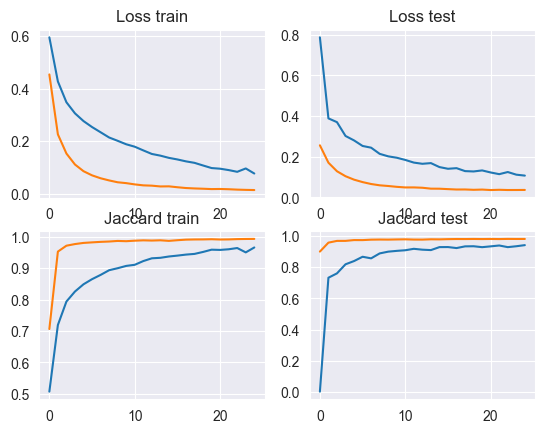

In [83]:
# compare with RMSprop model
f, axs = plt.subplots(2, 2)
axs[(0,0)].plot(df_opts[2].loss_train, label="loss_train_RMSprop")
axs[(0,0)].plot(df_resnet.loss_train, label="loss_train_resnet")
axs[(0,0)].set_title('Loss train')
axs[(0,1)].plot(df_opts[2].loss_test, label="loss_test_RMSprop")
axs[(0,1)].plot(df_resnet.loss_test, label="loss_test_resnet")
axs[(0,1)].set_title('Loss test')
axs[(1,0)].plot(df_opts[2].jac_train, label="jac_train_RMSprop")
axs[(1,0)].plot(df_resnet.jac_train, label="jac_train_resnet")
axs[(1,0)].set_title('Jaccard train')
axs[(1,1)].plot(df_opts[2].jac_test, label="jac_test_RMSprop")
axs[(1,1)].plot(df_resnet.jac_test, label="jac_test_resnet")
axs[(1,1)].set_title('Jaccard test')


Уже на пятой эпохе модель показывает результаты лучше чем модель без предобученного энкодера. Она значительно превосходит другие модели в точности предсказаний. Модель обучается гораздо быстрее и не улучшает результат после 20 эпохи. 

## Выводы

- Аугментация датасета хоть и дала прирост, но это связано лишь с увеличением количества данных на которых успела обучиться модель за 25 эпох
- Использование оптимизатора RMSprop позволило улучшить качество предсказаний по сравнению с Adam и AdamW
- Test time аугментация дала небольшой прирост точности предсказаний на худших изображениях. Также для некоторых изображений визуально заметно улучшение маски
- Увеличение количества сверток в нижнем слое Unet позволило улучшить качество модели.
- Предобученый энкодер дает очень хорошие результаты по сравнению с другими моделями.